In [30]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [31]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [32]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:xlabel='Date'>

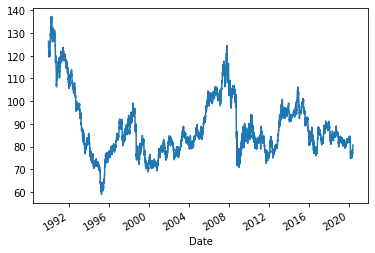

In [33]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot()

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** There was a significant decline in JPY price comparative to CAD in the 1990s. We see another significant decline for JPY at the time of the 2009 financial crisis.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [34]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate 
# price into two separate series:

ts_noise, ts_trend = sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

In [35]:
# Create a dataframe of just the exchange rate price, 
# and add columns for "noise" and "trend" series from above:
l1 = cad_jpy_df.index
l2 = cad_jpy_df.Price
l3 = ts_noise
l4 = ts_trend
price_df = pd.DataFrame(list(zip(l1, l2, l3, l4))) 
price_df.columns =['Date', 'Price', 'Noise', 'Trend']
price_df = price_df.set_index('Date')
price_df.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:xlabel='Price'>

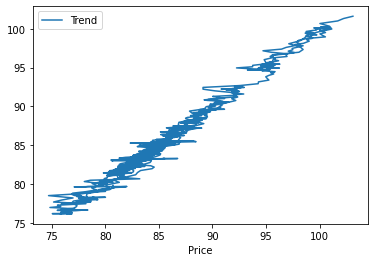

In [36]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
price_2015 = price_df.loc['2015':]
price_2015.plot(x='Price', y='Trend')

<AxesSubplot:xlabel='Date'>

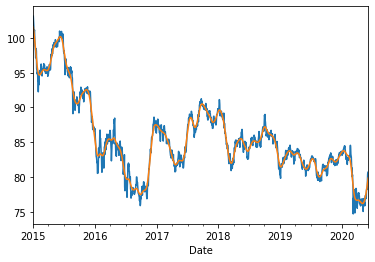

In [37]:
price_2015.Price.plot()
price_2015.Trend.plot()

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** We see a JPY peak in mid-2015, and lows in late 2016 and 2020.

<AxesSubplot:xlabel='Date'>

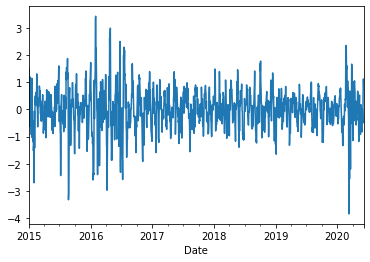

In [38]:
# Plot the Settle Noise
price_2015.Noise.plot()

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [54]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Returns'] = (cad_jpy_df[["Price"]].pct_change() * 100)
cad_jpy_df = cad_jpy_df.replace(-np.inf, np.nan).dropna()
cad_jpy_df.tail()

,Price,Open,High,Low,Returns
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


In [55]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(cad_jpy_df.Returns, order = (2,1))

# Fit the model and assign it to a variable called results
results= model.fit()

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23010D+00    |proj g|=  3.45590D-04

At iterate    5    f=  1.23010D+00    |proj g|=  3.60600D-05

At iterate   10    f=  1.23010D+00    |proj g|=  3.49720D-04


 This problem is unconstrained.



At iterate   15    f=  1.23008D+00    |proj g|=  2.19582D-03

At iterate   20    f=  1.23007D+00    |proj g|=  1.62981D-05

At iterate   25    f=  1.23007D+00    |proj g|=  8.88178D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     34      1     0     0   4.441D-08   1.230D+00
  F =   1.2300678291595062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [56]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                Returns   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Tue, 26 Apr 2022   AIC                          19513.955
Time:                        11:54:24   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.Returns    -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.Returns    -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.Returns     0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1697           +0.0000j           42.1697            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}, xlabel='Day', ylabel='Return'>

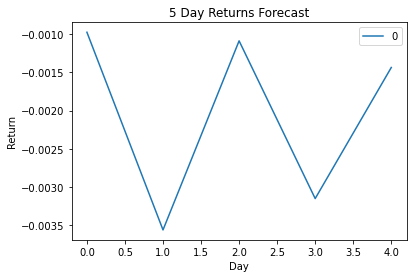

In [57]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast", xlabel = "Day", ylabel = "Return")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** Because some of the coefficients are above 0.05, the model is not statistically significant. For one lag the model is significant, but for two lags it is not. So this is not necessarily a good fit on this basis.

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [58]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(cad_jpy_df["Price"], order=(5, 1, 1))

# Fit the model
results = model.fit()

/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10305D+00    |proj g|=  2.28484D-04

At iterate    5    f=  1.10305D+00    |proj g|=  3.65485D-05

At iterate   10    f=  1.10305D+00    |proj g|=  4.84879D-04


 This problem is unconstrained.



At iterate   15    f=  1.10305D+00    |proj g|=  2.75113D-04

At iterate   20    f=  1.10305D+00    |proj g|=  3.55271D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     27      1     0     0   8.882D-08   1.103D+00
  F =   1.1030454849750249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [59]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7927
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8743.842
Method:                       css-mle   S.D. of innovations              0.729
Date:                Tue, 26 Apr 2022   AIC                          17503.683
Time:                        11:54:41   BIC                          17559.507
Sample:                             1   HQIC                         17522.800
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0056      0.008     -0.726      0.468      -0.021       0.010
ar.L1.D.Price     0.4302      0.248      1.734      0.083      -0.056       0.916
ar.L2.D.Price     0.0183      0.014      1.294      0.196      -0.009       0.046
ar.L3.D.Price    -0.0120      0.012     -0.973      0.330      -0.036       0.012
ar.L4.D.Price     0.0112      0.012      0.899      0.368      -0.013       0.036
ar.L5.D.Price    -0.0191      0.011     -1.697      0.090      -0.041       0.003
ma.L1.D.Price    -0.4587      0.248     -1.850      0.064      -0.945       0.027
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7694           -0.7660j            1.9281           -0.0650
AR.2            1.7694           +0.7660j            1.9281            0.0650
AR.3           -2.3631           -0.0000j            2.3631           -0.5000
AR.4           -0.2940           -2.4243j            2.4421           -0.2692
AR.5           -0.2940           +2.4243j            2.4421            0.2692
MA.1            2.1800           +0.0000j            2.1800            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Price Forecast'}>

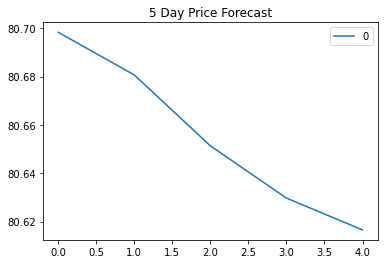

In [60]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** A decrease in JPY price in the short term.

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [46]:
import arch as arch

In [61]:
# Estimate a GARCH model:
from arch import arch_model
model = arch_model(cad_jpy_df['Returns'], mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
res = model.fit(disp="off")

In [62]:
# Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Tue, Apr 26 2022   Df Residuals:                     7928
Time:                        11:55:30   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [63]:
# Find the last day of the dataset
last_day = cad_jpy_df.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [64]:
type(last_day)

str

In [65]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2020-06-04', horizon=forecast_horizon)
forecasts

In [66]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [67]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:>

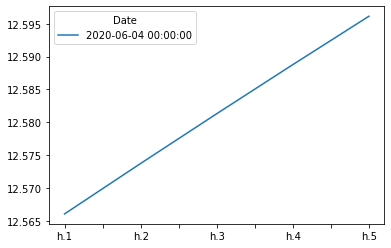

In [68]:
# Plot the final forecast
final.plot()

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** Volatility will increase in the near term

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

    * No, as the forecast indicates negative returns, as well as increased volatility.

2. Is the risk of the yen expected to increase or decrease?
    * Given that volatility is expected to increase, risk would also increase

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * Of the models, GARCH is better given two of the p-values are below 0.05. The ARIMA and ARMA model have a number of p-values above 0.05 so I would be less confident using these.